## Import Libraries and Dataset

In [ ]:
# Import library
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

# Declare variable and get data from sheet
sheet_url= 'https://docs.google.com/spreadsheets/d/1RItbgG4TEzr5Bg5p8MiRDtFJ3iuxa8Iz/edit#gid=875125215'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=xlsx&gid=')

df = pd.read_excel(sheet_url_trf)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# get dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Remove Duplicates

In [ ]:
# Find duplicate rows
duplicate = df[df.duplicated('InvoiceNo')]
print("Duplicate Rows :{}".format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))

Duplicate Rows :5268
1% rows are duplicate.


In [ ]:
# Drop duplicate rows, since duplicate invoice is only 1% of total
df.drop_duplicates(inplace = True)

In [ ]:
# Check total number of products, transactions and customers
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


## Remove Canceled Order From Dataset

In [ ]:
# Based on the dataset info, canceled order is marked by letter c before of Invoice Number
invoice = df['InvoiceNo']

In [ ]:
canceled = invoice.str.contains('C', regex=True)
canceled.fillna(0, inplace=True)
canceled = canceled.astype(int)
canceled.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [ ]:
df['canceled'] = canceled
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [ ]:
df.shape

(536641, 9)

In [ ]:
# Count percentage of cancelled orders
n1 = df['canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 9251/536641 (1.72%) 


In [ ]:
# Remove cancelled orders
df = df.loc[df['canceled'] == 0,:]
df.reset_index(drop=True,inplace=True)
df.shape

(527390, 9)

## Adding New Column: TotalPrice

We need to calculate total price of every order by multiplying quantity with unit price

In [ ]:
# But first, make sure no < 0 or minus value in both Quantity and Unitprice columns
df = df.loc[df['Quantity'] > 0]
df.shape

(526054, 9)

In [ ]:
df = df.loc[df['UnitPrice'] > 0]
df.shape

(524878, 9)

In [ ]:
# Calculate Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [ ]:
# Final step to make sure no < 0 or minus value in Total Price column
df = df.loc[df['TotalPrice'] > 0]
df.shape

(524878, 10)

In [ ]:
# Check total number of products, transactions and customers in clean data
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3922,19960,4338


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524878 entries, 0 to 527389
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    524878 non-null  object        
 1   StockCode    524878 non-null  object        
 2   Description  524878 non-null  object        
 3   Quantity     524878 non-null  int64         
 4   InvoiceDate  524878 non-null  datetime64[ns]
 5   UnitPrice    524878 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      524878 non-null  object        
 8   canceled     524878 non-null  int64         
 9   TotalPrice   524878 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 44.0+ MB


##Remove Outlier

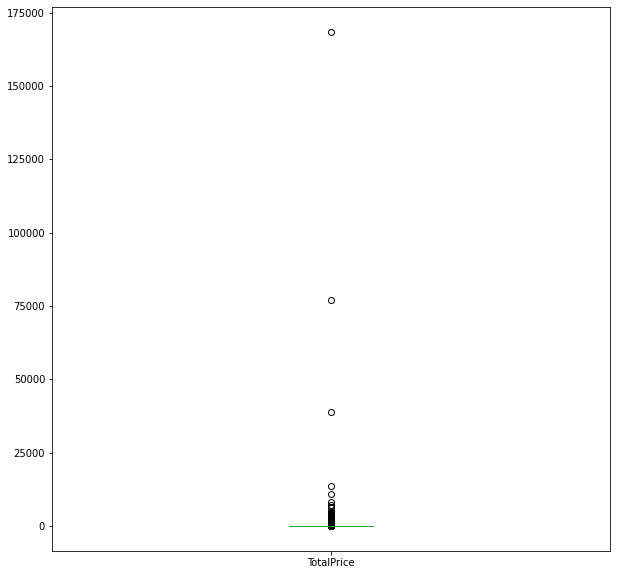

In [ ]:
# We want to remove outlier from TotalPrice column
df.boxplot(column='TotalPrice', fontsize=10, rot=0, grid=False, figsize=(10, 10))

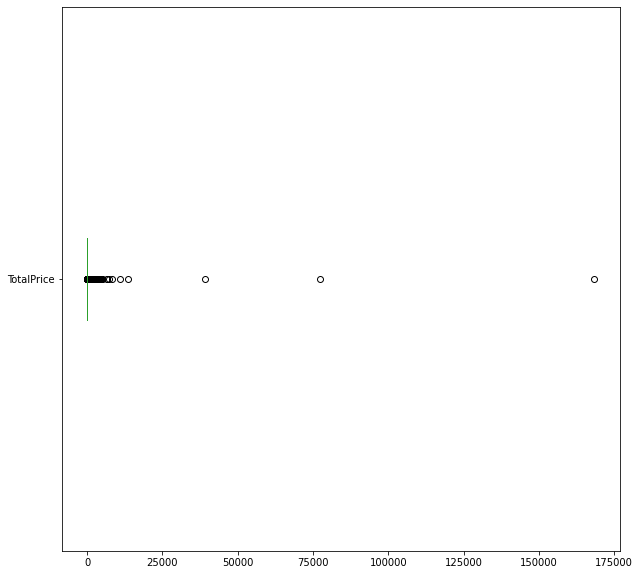

In [ ]:
df.boxplot(column=['TotalPrice'],fontsize=10,
           rot=0,grid=False,figsize=(10,10),vert=False)

In [ ]:
# IQR calculation Test

Q1t = df[['TotalPrice']].quantile(0.25)
Q3t = df[['TotalPrice']].quantile(0.75)

IQRt = Q3t - Q1t
boxplot_min = Q1t - 1.5 * IQRt
boxplot_max = Q3t + 1.5 * IQRt
print('Q1:\n',Q1t)
print('\nQ3:\n',Q3t)
print('\nIQR:\n',IQRt)
print('\nMin:\n',boxplot_min)
print('\nMax:\n',boxplot_max)

Q1:
 TotalPrice    3.9
Name: 0.25, dtype: float64

Q3:
 TotalPrice    17.7
Name: 0.75, dtype: float64

IQR:
 TotalPrice    13.8
dtype: float64

Min:
 TotalPrice   -16.8
dtype: float64

Max:
 TotalPrice    38.4
dtype: float64


In [ ]:
df['TotalPrice'].describe()

count    524878.000000
mean         20.275399
std         271.693566
min           0.001000
25%           3.900000
50%           9.920000
75%          17.700000
max      168469.600000
Name: TotalPrice, dtype: float64

In [ ]:
#Remove Outlier
filter_totalprice_min = df['TotalPrice'] < -16.8
filter_totalprice_max = df['TotalPrice'] > 38.4

df_clean = df.copy()
df_clean = df[~
    (filter_totalprice_min|filter_totalprice_max)
    ]

df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
527385,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20
527386,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60
527387,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60
527388,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60


## Saving Clean Dataset

In [ ]:
df_clean.to_excel("GroupB_clean.xlsx")

In [ ]:
df_clean.to_csv('GroupB_clean.csv')

## Further Exploration

In [ ]:
# Checking total number of unique customer
df_clean.CustomerID.nunique()

4185

In [ ]:
pd.DataFrame([{'Products': (df_clean['StockCode'].nunique()),    
               'Transactions': (df_clean['InvoiceNo'].nunique()),
               'Customers': (df_clean['CustomerID'].nunique()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Total'])

,Products,Transactions,Customers
Total,3894,18088,4185


## Further Cleaning

In [ ]:
grouped_df = df.groupby('CustomerID')
grouped_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
527249,581578,POST,POSTAGE,3,2011-12-09 12:16:00,18.00,12713.0,Germany,0,54.00
527250,581578,21124,SET/10 BLUE POLKADOT PARTY CANDLES,24,2011-12-09 12:16:00,1.25,12713.0,Germany,0,30.00
527251,581578,21122,SET/10 PINK POLKADOT PARTY CANDLES,24,2011-12-09 12:16:00,1.25,12713.0,Germany,0,30.00
527252,581578,21121,SET/10 RED POLKADOT PARTY CANDLES,24,2011-12-09 12:16:00,1.25,12713.0,Germany,0,30.00


In [ ]:
grouped_df = df.groupby('CustomerID')
grouped_df = grouped_df.agg({'InvoiceNo': 'nunique'})
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [ ]:
# create and group by InvoiceNo and Customer ID
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_TotalPrice = df.groupby(['InvoiceNo', 'CustomerID'], as_index=False, dropna=False).agg({'TotalPrice': 'sum'})
df_TotalPrice.sort_values('CustomerID', inplace=True, ascending=False)
df_TotalPrice

,InvoiceNo,CustomerID,TotalPrice
16139,573167,18287.0,70.68
15057,570715,18287.0,1001.32
7661,554065,18287.0,765.28
3695,545079,18283.0,100.95
7738,554157,18283.0,85.22
...,...,...,...
19892,581439,NaN,6637.59
19930,581492,NaN,7689.23
19935,581497,NaN,3217.20
19936,581498,NaN,5664.89


In [ ]:
# group by customer ID
df_TotalPrice1 = df_TotalPrice.groupby(['CustomerID'], as_index=False, dropna=False).agg({'TotalPrice': 'sum'})
df_TotalPrice1.sort_values('TotalPrice', inplace=True, ascending=False)
df_TotalPrice1

,CustomerID,TotalPrice
4338,NaN,1754901.91
1689,14646.0,280206.02
4201,18102.0,259657.30
3728,17450.0,194390.79
3008,16446.0,168472.50
...,...,...
3323,16878.0,13.30
4098,17956.0,12.75
3014,16454.0,6.90
1793,14792.0,6.20


## RFM Segmentation



In [ ]:
from dateutil.relativedelta import relativedelta

all_dates = (pd.to_datetime(df_clean['InvoiceDate'])).apply(lambda x:x.date())
start_date = all_dates.max()-relativedelta(months=12,days=-1)
print('Start date: {}'.format(start_date))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-10
End date: 2011-12-09


In [ ]:
data_rfm = df_clean[df_clean['InvoiceDate'] >= pd.to_datetime(start_date)]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled,TotalPrice
0,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,0,15.0
1,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805.0,United Kingdom,0,30.6
2,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805.0,United Kingdom,0,35.4
3,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805.0,United Kingdom,0,13.2
4,538172,21098,CHRISTMAS TOILET ROLL,24,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,0,30.0


In [ ]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462278 entries, 0 to 462277
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    462278 non-null  object        
 1   StockCode    462278 non-null  object        
 2   Description  462278 non-null  object        
 3   Quantity     462278 non-null  int64         
 4   InvoiceDate  462278 non-null  datetime64[ns]
 5   UnitPrice    462278 non-null  float64       
 6   CustomerID   343151 non-null  float64       
 7   Country      462278 non-null  object        
 8   canceled     462278 non-null  int64         
 9   TotalPrice   462278 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 35.3+ MB


In [ ]:
snapshot_date = max(data_rfm.InvoiceDate) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2011-12-10


In [ ]:
# Aggregate data on a customer level
data = data_rfm.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                             'InvoiceNo': 'count',
                                             'TotalPrice': 'sum'}).rename(columns = {'InvoiceDate': 'Recency',
                                                                                   'InvoiceNo': 'Frequency',
                                                                                   'TotalPrice': 'MonetaryValue'})

# Check the first rows
data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12347.0,2,137,2510.23
1,12348.0,249,7,111.08
2,12349.0,19,65,1105.40
3,12350.0,310,16,294.40
4,12352.0,36,77,1385.74


In [ ]:
r_labels = range(4, 0, -1)
f_labels = range(1,5)
m_labels = range(1,5)
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
f_quartiles = pd.qcut(data['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels = m_labels)
data = data.assign(R = r_quartiles.values)
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12347.0,2,137,2510.23,4,4,4
1,12348.0,249,7,111.08,1,1,1
2,12349.0,19,65,1105.40,3,3,4
3,12350.0,310,16,294.40,1,1,2
4,12352.0,36,77,1385.74,3,3,4


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4112 entries, 0 to 4111
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CustomerID     4112 non-null   float64 
 1   Recency        4112 non-null   int64   
 2   Frequency      4112 non-null   int64   
 3   MonetaryValue  4112 non-null   float64 
 4   R              4112 non-null   category
 5   F              4112 non-null   category
 6   M              4112 non-null   category
dtypes: category(3), float64(2), int64(2)
memory usage: 173.1 KB


In [ ]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data['RFM_Segment'] = data.apply(join_rfm, axis=1)
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12347.0,2,137,2510.23,4,4,4,4.04.04.0,12
1,12348.0,249,7,111.08,1,1,1,1.01.01.0,3
2,12349.0,19,65,1105.40,3,3,4,3.03.04.0,10
3,12350.0,310,16,294.40,1,1,2,1.01.02.0,4
4,12352.0,36,77,1385.74,3,3,4,3.03.04.0,10


In [ ]:
RFM_score_df = data.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)
RFM_score_df

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           240.2       7.0         106.1   390
4           150.7      11.9         149.8   377
5           139.2      18.0         242.4   440
6            96.5      25.3         305.5   460
7            86.8      37.8         462.8   417
8            59.6      49.4         618.6   418
9            46.5      69.1         849.0   386
10           34.9     105.5        1253.6   413
11           21.9     172.0        2000.5   366
12            7.4     329.9        3682.1   445

In [ ]:
def create_segment(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'
    
data['General_Segment'] = data.apply(create_segment, axis=1)
general_segment_stat = data.groupby('General_Segment').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']}).round(1)
general_segment_stat

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Low               196.2       9.4         127.6   767
Middle             96.1      32.3         402.7  1735
Top                27.1     173.9        1997.6  1610

## Saving RFM Segmentation Result

In [ ]:
data.to_excel("GroupB_RFM.xlsx")

In [ ]:
data.to_csv("GroupB_RFM.csv")

In [ ]:
RFM_score_df.to_excel("GroupB_RFM_score.xlsx")

In [ ]:
general_segment_stat.to_excel("GroupB_RFM_general_segment_stat.xlsx")

## RFM Clustering

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

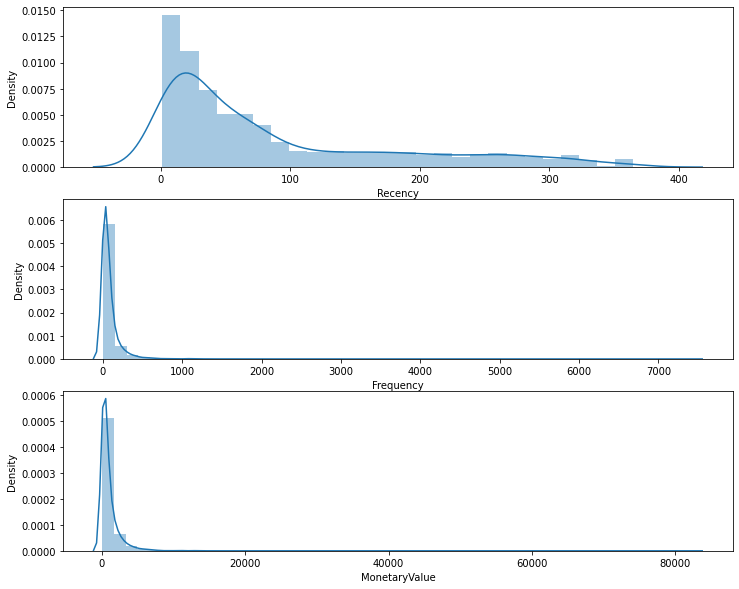

In [ ]:
# Prepare data for Kmeans clustering

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])

In [ ]:
# Checking for constant mean and variance.
data[['Recency','Frequency','MonetaryValue']].describe()

,Recency,Frequency,MonetaryValue
count,4112.000000,4112.000000,4112.000000
mean,87.780156,83.451119,975.880743
std,93.505385,210.434346,2066.229333
min,1.000000,1.000000,1.900000
25%,18.000000,16.000000,205.287500
50%,50.000000,38.000000,472.560000
75%,134.000000,91.000000,1102.590000
max,365.000000,7433.000000,82562.170000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4112 entries, 0 to 4111
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerID       4112 non-null   float64 
 1   Recency          4112 non-null   int64   
 2   Frequency        4112 non-null   int64   
 3   MonetaryValue    4112 non-null   float64 
 4   R                4112 non-null   category
 5   F                4112 non-null   category
 6   M                4112 non-null   category
 7   RFM_Segment      4112 non-null   object  
 8   RFM_Score        4112 non-null   int64   
 9   General_Segment  4112 non-null   object  
dtypes: category(3), float64(2), int64(3), object(2)
memory usage: 429.4+ KB


In [ ]:
# Unskew the data
raw_data = data[['Recency','Frequency','MonetaryValue']]
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [ ]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,0.693147,4.919981,7.828130
1,5.517453,1.945910,4.710251
2,2.944439,4.174387,7.007963
3,5.736572,2.772589,5.684939
4,3.583519,4.343805,7.233990


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

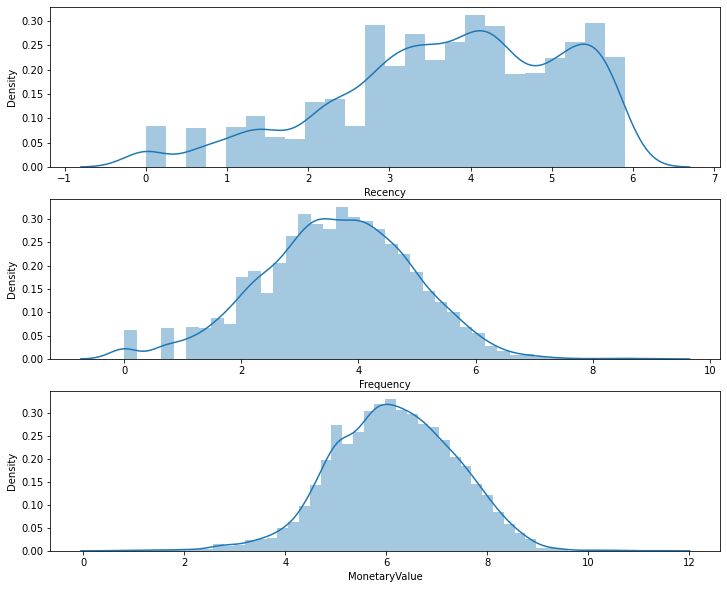

In [ ]:
# Check for normalized skewness

plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

# Show the plot
plt.show()

In [ ]:
from sklearn.cluster import KMeans
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 8):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

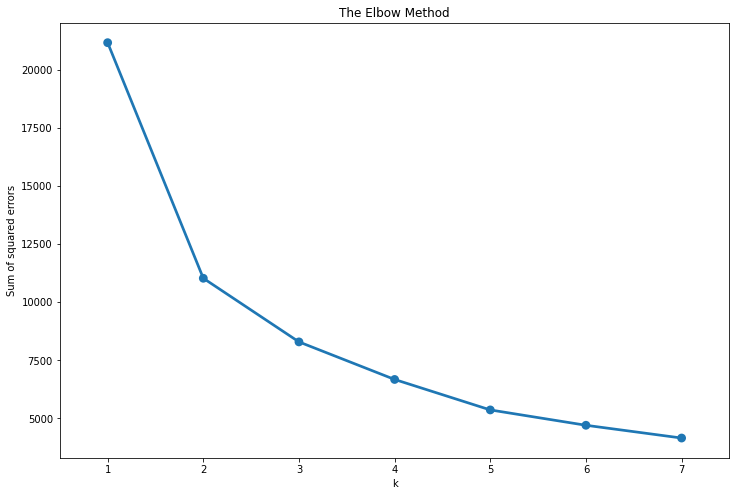

In [ ]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
cluster_fields = ['Recency','Frequency','MonetaryValue']
for n_cluster in range(3, 7):
    kmeans = KMeans(n_clusters=n_cluster).fit(data_norm[cluster_fields])
    label = kmeans.labels_
    sil_coeff = silhouette_score(data_norm[cluster_fields], label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=3, The Silhouette Coefficient is 0.31495875800647827
For n_clusters=4, The Silhouette Coefficient is 0.31807007014954547
For n_clusters=5, The Silhouette Coefficient is 0.3179905521481503
For n_clusters=6, The Silhouette Coefficient is 0.29839541354530347


In [ ]:
# Try k = 3

kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          13.0     206.0        2331.0  1129
1         157.0      11.0         149.0  1219
2          88.0      55.0         680.0  1764

In [ ]:
# Try k = 4

kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          18.0      38.0         446.0   827
1         164.0       9.0         130.0   964
2          17.0     240.0        2719.0   960
3         126.0      53.0         667.0  1361

In [ ]:
# Compare k = 3 and k = 4
display(summary_k3)
display(summary_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          13.0     206.0        2331.0  1129
1         157.0      11.0         149.0  1219
2          88.0      55.0         680.0  1764

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          18.0      38.0         446.0   827
1         164.0       9.0         130.0   964
2          17.0     240.0        2719.0   960
3         126.0      53.0         667.0  1361

In [ ]:
data_norm_k3.index = data['CustomerID'].astype(int)
data_norm_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,0.693147,4.919981,7.828130,0
12348,5.517453,1.945910,4.710251,1
12349,2.944439,4.174387,7.007963,0
12350,5.736572,2.772589,5.684939,1
12352,3.583519,4.343805,7.233990,2


In [ ]:
data_norm_k4.index = data['CustomerID'].astype(int)
data_norm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,0.693147,4.919981,7.828130,2
12348,5.517453,1.945910,4.710251,1
12349,2.944439,4.174387,7.007963,2
12350,5.736572,2.772589,5.684939,1
12352,3.583519,4.343805,7.233990,3


In [ ]:
data_norm_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,0.693147,4.919981,7.828130,0
12348,5.517453,1.945910,4.710251,1
12349,2.944439,4.174387,7.007963,0
12350,5.736572,2.772589,5.684939,1
12352,3.583519,4.343805,7.233990,2


In [ ]:
data_norm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,0.693147,4.919981,7.828130,2
12348,5.517453,1.945910,4.710251,1
12349,2.944439,4.174387,7.007963,2
12350,5.736572,2.772589,5.684939,1
12352,3.583519,4.343805,7.233990,3


## Saving RFM Cluster Result

In [ ]:
data_norm_k3.to_excel("RFM Cluster 3.xlsx")

In [ ]:
data_k3.to_excel("3 Cluster.xlsx")

In [ ]:
data_norm_k4.to_excel("RFM Cluster 4.xlsx")

In [ ]:
data_k4.to_excel("4 Cluster.xlsx")

In [ ]:
summary_k3.to_excel("Summary Cluster 3.xlsx")

In [ ]:
summary_k4.to_excel("Summary Cluster 4.xlsx")